In [18]:
import numpy as np
import cv2
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import tensorflow as tf

In [19]:
# **Loading Dataset**
data_train = np.load('/content/train_set.npz', allow_pickle=True)
x_train = data_train['arr_0']
y_train = data_train['arr_1']

data_test = np.load('/content/test_set.npz', allow_pickle=True)
x_test = data_test['arr_0']
y_test = data_test['arr_1']

In [20]:
train_data_generator = ImageDataGenerator(
    rotation_range=60,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,  # Vertical flip might not make sense depending on your dataset

)


x = list(x_train)
y = list(y_train)

x_aug_train = []
y_aug_train = []

for (i, v) in enumerate(y):
    x_img = x[i]
    x_img = np.array(x_img)
    x_img = np.expand_dims(x_img, axis=0)
    aug_iter = train_data_generator.flow(x_img, batch_size=1, shuffle=True)
    for j in range(10):
        aug_image = next(aug_iter)[0].astype('uint8')
        x_aug_train.append(aug_image)
        y_aug_train.append(v)
print(len(x_aug_train))
print(len(y_aug_train))

x_train = x + x_aug_train
y_train = y + y_aug_train
print(len(x_train))
print(len(y_train))

test_data_generator = ImageDataGenerator(rotation_range=60,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
#                                     brightness_range=[0.5, 1.5],
                                    zoom_range=0.1,
                                    horizontal_flip=True,
                                    vertical_flip=True)

x = list(x_test)
y = list(y_test)

x_aug_test = []
y_aug_test = []

for (i, v) in enumerate(y):
    x_img = x[i]
    x_img = np.array(x_img)
    x_img = np.expand_dims(x_img, axis=0)
    aug_iter = test_data_generator.flow(x_img, batch_size=1, shuffle=True)
    for j in range(5):
        aug_image = next(aug_iter)[0].astype('uint8')
        x_aug_test.append(aug_image)
        y_aug_test.append(v)
print(len(x_aug_test))
print(len(y_aug_test))

x_test = x + x_aug_test
y_test = y + y_aug_test
print(len(x_test))
print(len(y_test))

720
720
792
792
150
150
180
180


In [21]:
# **Data Preprocessing**
x_train = np.array(x_train)
x_test = np.array(x_test)

# Initialize new arrays for resized images
x_train_resized = np.empty((x_train.shape[0], 224, 224, 3), dtype=np.float32)
x_test_resized = np.empty((x_test.shape[0], 224, 224, 3), dtype=np.float32)


for i in range(len(x_train)):
    img = x_train[i]
    img = cv2.resize(img, (224, 224))  # ResNet101 requires 224x224 input size
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x_train_resized[i] = img

for i in range(len(x_test)):
    img = x_test[i]
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x_test_resized[i] = img

# Normalize the images
x_train_resized /= 255.0
x_test_resized /= 255.0

# Use the resized images for training and testing
x_train = x_train_resized
x_test = x_test_resized

# Encoding labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [22]:
# **Model Defining**
def create_resnet101_model(input_shape=(224, 224, 3)):
    base_model = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = Flatten()(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs, outputs)
    optimizer = Adam(3.15e-5)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [23]:

model = create_resnet101_model()
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet101 (Functional)               │ (None, 7, 7, 2048)          │      42,658,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │       6,422,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,080,898 (187.23 MB)

 Trainable params: 6,422,722 (24.50 MB)

 Non-trainable params: 42,658,176 (162.73 MB)

In [24]:
# **Model Training**
hist = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.4968 - loss: 0.9413 - val_accuracy: 0.5056 - val_loss: 0.7151
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 182ms/step - accuracy: 0.5069 - loss: 0.7553 - val_accuracy: 0.5000 - val_loss: 0.7192
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 0.5168 - loss: 0.7438 - val_accuracy: 0.5222 - val_loss: 0.6934
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 207ms/step - accuracy: 0.5486 - loss: 0.7011 - val_accuracy: 0.4944 - val_loss: 0.6968
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 208ms/step - accuracy: 0.5066 - loss: 0.7091 - val_accuracy: 0.5167 - val_loss: 0.6932
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - accuracy: 0.5394 - loss: 0.6923 - val_accuracy: 0.5000 - val_loss: 0.6910
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - accuracy: 0.5225 - loss: 0.6914 - val_accuracy: 0.5611 - val_loss: 0.6907
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 206ms/step - accuracy: 0.5367 - loss: 0.6926 - val_accuracy: 0

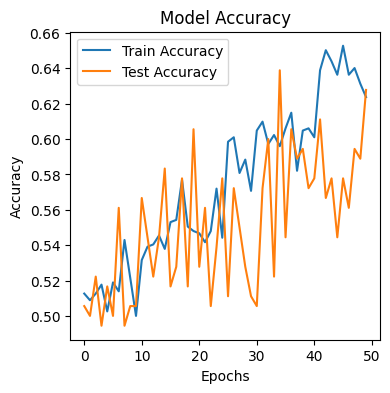

In [25]:
# **Visualization of Training History**
plt.figure(figsize=(4,4))
plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

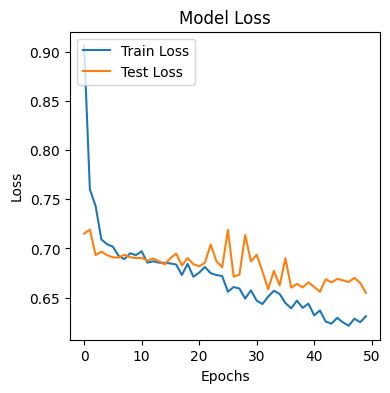

In [26]:
plt.figure(figsize=(4,4))
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()


In [27]:
# **Save the Model**
model.save('parkinson_disease_detection_resnet101.h5')

In [28]:
# **Evaluation**
ypred = model.predict(x_test)
ypred = np.argmax(ypred, axis=1)
y_test_pred = np.argmax(y_test, axis=1)
print(classification_report(y_test_pred, ypred))

6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step
              precision    recall  f1-score   support

           0       0.60      0.77      0.67        90
           1       0.68      0.49      0.57        90

    accuracy                           0.63       180
   macro avg       0.64      0.63      0.62       180
weighted avg       0.64      0.63      0.62       180



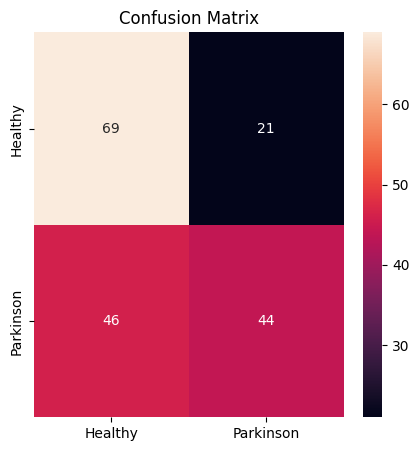

In [29]:
# **Confusion Matrix**
matrix = confusion_matrix(y_test_pred, ypred)
df_cm = pd.DataFrame(matrix, index=['Healthy', 'Parkinson'], columns=['Healthy', 'Parkinson'])
plt.figure(figsize=(5, 5))
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# **Testing with Sample Images**
labels = ['Healthy', 'Parkinson']
image_healthy = cv2.imread('Parkinson_disease_detection/test_image_healthy.png')
image_parkinson = cv2.imread('Parkinson_disease_detection/test_image_parkinson.png')

def prepare_image(image):
    image = cv2.resize(image, (224, 224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    return image

In [ ]:
image_healthy_prepared = prepare_image(image_healthy)
image_parkinson_prepared = prepare_image(image_parkinson)


In [ ]:
ypred_healthy = model.predict(image_healthy_prepared)
ypred_parkinson = model.predict(image_parkinson_prepared)

1/1 [==============================] - 0s 137ms/step


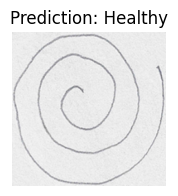

In [ ]:

plt.figure(figsize=(2, 2))
plt.imshow(image_healthy_prepared[0])
plt.axis('off')
plt.title(f'Prediction: {labels[np.argmax(ypred_healthy[0])]}')
plt.show()

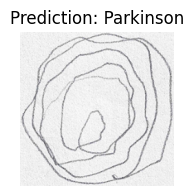

In [ ]:

plt.figure(figsize=(2, 2))
plt.imshow(image_parkinson_prepared[0])
plt.axis('off')
plt.title(f'Prediction: {labels[np.argmax(ypred_parkinson[0])]}')
plt.show()